In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt
import gdown
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y'
output = 'Dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y
To: /content/Dataset.zip
100%|██████████| 197M/197M [00:05<00:00, 36.0MB/s]


'Dataset.zip'

In [3]:
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Preprocessed Dataset/val/altered_frames_cropped/r7B491zbxnw_0_pXJ6HOsm_iY_0.avi_frame_690.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/s8CuBT-MDYE_4_sZqIjquRfck_8.avi_frame_150.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/szxR2kMIWtI_0_saQyF1FPiqw_0.avi_frame_270.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/qpBoMZ8mAiQ_2_qpe2zydDOBM_0.avi_frame_210.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wTsoXbhr0N8_4_wnx2fsN9WP0_1.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvxJpaN72WQ_2.avi_frame_60.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/rBgM58w-gvM_1_pd8-LGKVGWQ_3.avi_frame_540.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/sZDvg03saDA_4_sZDvg03saDA_4.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvx

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root='Preprocessed Dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='Preprocessed Dataset/val', transform=transform)
test_dataset = datasets.ImageFolder(root='Preprocessed Dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
def check_data_loader_dim(loader):
    # Checking the dataset
    for images, labels in loader:
        print('Image batch dimensions:', images.shape)
        print('Image label dimensions:', labels.shape)
        break

check_data_loader_dim(train_loader)
check_data_loader_dim(val_loader)
check_data_loader_dim(test_loader)

Image batch dimensions: torch.Size([32, 3, 299, 299])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 299, 299])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 299, 299])
Image label dimensions: torch.Size([32])


In [6]:
model = models.inception_v3(pretrained=True)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 1)

# Replace the last fully connected layer (fc) for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 57.1MB/s]


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            if model.training and isinstance(outputs, tuple):
                main_output, aux_output = outputs
                loss1 = criterion(main_output, labels.view(-1, 1).float())
                loss2 = criterion(aux_output, labels.view(-1, 1).float())
                loss = loss1 + 0.4 * loss2
                preds = torch.sigmoid(main_output) > 0.5
            else:
                loss = criterion(outputs, labels.view(-1, 1).float())
                preds = torch.sigmoid(outputs) > 0.5

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.view(-1, 1).data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation Phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs, _ = outputs
                loss = criterion(outputs, labels.view(-1, 1).float())
                running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs) > 0.5
                running_corrects += torch.sum(preds == labels.view(-1, 1).data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    return model, (train_losses, train_accuracies, val_losses, val_accuracies)


In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device=device)


Epoch 1/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 1/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 1/25
Train Loss: 0.7882 Acc: 0.7579
Validation Loss: 0.4223 Acc: 0.8190


Epoch 2/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 2/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/25
Train Loss: 0.7287 Acc: 0.7920
Validation Loss: 0.3924 Acc: 0.8305


Epoch 3/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 3/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/25
Train Loss: 0.7164 Acc: 0.7992
Validation Loss: 0.3919 Acc: 0.8244


Epoch 4/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 4/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/25
Train Loss: 0.7145 Acc: 0.7998
Validation Loss: 0.3761 Acc: 0.8399


Epoch 5/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 5/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/25
Train Loss: 0.7207 Acc: 0.7965
Validation Loss: 0.3711 Acc: 0.8427


Epoch 6/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 6/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/25
Train Loss: 0.7141 Acc: 0.8022
Validation Loss: 0.3641 Acc: 0.8475


Epoch 7/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 7/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/25
Train Loss: 0.7173 Acc: 0.7962
Validation Loss: 0.3677 Acc: 0.8471


Epoch 8/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 8/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/25
Train Loss: 0.7124 Acc: 0.8005
Validation Loss: 0.3680 Acc: 0.8404


Epoch 9/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 9/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/25
Train Loss: 0.7216 Acc: 0.7967
Validation Loss: 0.3736 Acc: 0.8421


Epoch 10/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 10/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/25
Train Loss: 0.7164 Acc: 0.7996
Validation Loss: 0.3656 Acc: 0.8456


Epoch 11/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 11/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 11/25
Train Loss: 0.7113 Acc: 0.7982
Validation Loss: 0.3741 Acc: 0.8326


Epoch 12/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 12/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/25
Train Loss: 0.7215 Acc: 0.7988
Validation Loss: 0.3683 Acc: 0.8450


Epoch 13/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 13/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/25
Train Loss: 0.7086 Acc: 0.8038
Validation Loss: 0.3828 Acc: 0.8263


Epoch 14/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 14/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/25
Train Loss: 0.7208 Acc: 0.7969
Validation Loss: 0.3764 Acc: 0.8320


Epoch 15/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 15/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/25
Train Loss: 0.7172 Acc: 0.7999
Validation Loss: 0.3726 Acc: 0.8372


Epoch 16/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 16/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/25
Train Loss: 0.7139 Acc: 0.7983
Validation Loss: 0.3721 Acc: 0.8360


Epoch 17/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 17/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/25
Train Loss: 0.7170 Acc: 0.7967
Validation Loss: 0.3840 Acc: 0.8253


Epoch 18/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 18/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/25
Train Loss: 0.7193 Acc: 0.7962
Validation Loss: 0.3770 Acc: 0.8284


Epoch 19/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 19/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/25
Train Loss: 0.7241 Acc: 0.7961
Validation Loss: 0.3668 Acc: 0.8418


Epoch 20/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 20/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/25
Train Loss: 0.7151 Acc: 0.7989
Validation Loss: 0.3673 Acc: 0.8418


Epoch 21/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 21/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 21/25
Train Loss: 0.7124 Acc: 0.8001
Validation Loss: 0.3686 Acc: 0.8463


Epoch 22/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 22/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/25
Train Loss: 0.7214 Acc: 0.7970
Validation Loss: 0.3706 Acc: 0.8353


Epoch 23/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 23/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/25
Train Loss: 0.7162 Acc: 0.8021
Validation Loss: 0.3661 Acc: 0.8460


Epoch 24/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 24/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/25
Train Loss: 0.7213 Acc: 0.7953
Validation Loss: 0.3692 Acc: 0.8387


Epoch 25/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 25/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/25
Train Loss: 0.7196 Acc: 0.8006
Validation Loss: 0.3603 Acc: 0.8490


In [10]:
train_accuracy = [accuracy.cpu().item() for accuracy in metrics[1]]
val_accuracy = [accuracy.cpu().item() for accuracy in metrics[3]]

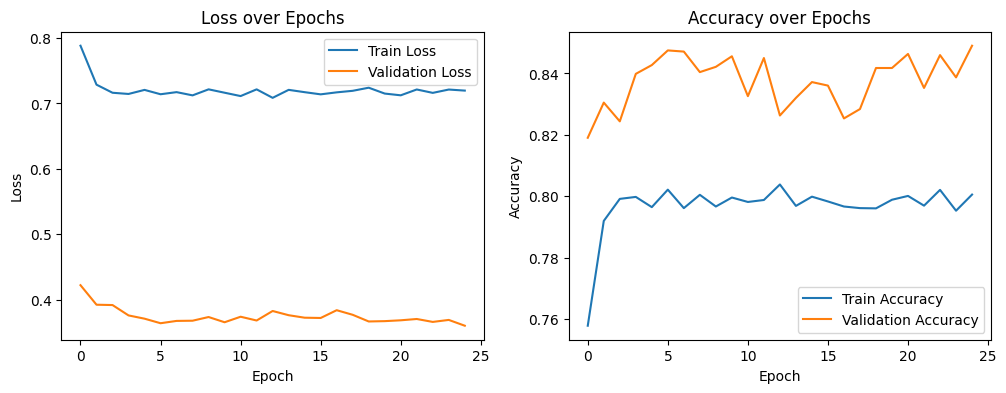

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(metrics[0], label='Train Loss')
plt.plot(metrics[2], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [12]:
torch.save(trained_model, 'InceptionV3_model.pth')

In [13]:
# Load the entire model
trained_model = torch.load('/content/InceptionV3_model.pth')

# Set to evaluation mode for inference
trained_model.eval()

# Move model to the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [14]:
trained_model.eval()

test_loss = 0
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for data, target in test_loader:
        # Moving data to the same device as model
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = trained_model(data)

        # Compute the loss
        test_loss += criterion(output, target.view(-1, 1).float()).item()

        # Convert output probabilities to predicted class
        preds = output > 0.0

        # Count correct predictions
        correct += torch.sum(preds == target.view(-1, 1).data).item()
        total += target.size(0)

# Calculate average loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.0117, Test Accuracy: 0.8426


In [15]:
trained_model.eval()

# Lists to store actual and predicted labels
actuals = []
predictions = []

# Iterate over the test_loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Get predictions from the model
    with torch.no_grad():
        outputs = trained_model(images)

    # Apply sigmoid and round to get the binary class
    predicted_labels = torch.round(torch.sigmoid(outputs)).squeeze()

    # Store the true and predicted labels
    actuals.extend(labels.cpu().numpy())
    predictions.extend(predicted_labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)

# Calculate precision, recall, f1-score, and support
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')

# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[2106  591]
 [ 258 2439]]

Accuracy: 84.26%
Precision: 0.804950495049505
Recall: 0.9043381535038932
F1 Score: 0.851754845468832
